<center><b><font size=6>Lab-7 Supervised Learning<b><center>

### Objective: build a basic ML pipeline for classification problem:
1. **Data segmentation** is used to split the whole dataset into different portions for different purpose - training, validation, and test. Useful link: <a href="https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets">Wiki</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">sklearn</a>.
2. **Usage of classification algorithms using Scikit-learn (sklearn)**: we will use classification algorithms already implemented in sklearn libraries. Useful link: <a href="https://en.wikipedia.org/wiki/Statistical_classification">Wiki</a>, <a href="https://scikit-learn.org/stable/auto_examples/classification/index.html#classification">examples in sklearn</a>.
3. **Performance evaluation**: we will also refer to sklearn libraries to use different metrics to evaluate trained model performance. Useful link: <a href="https://en.wikipedia.org/wiki/Confusion_matrix">Wiki</a>, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">sklearn</a>.

In [1]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

### 1. Tutorial - Classification
Classification is supervised learning, for which you have labeled data to build/tune/evaluate ML models to classify/predict future samples, helping to make decisions, forecast conditions, identify patterns, etc. 



Here we use the IRIS dataset as an example to show how you can perform classification. 

In [2]:
# load dataset of IRIS flowers

from sklearn import datasets
iris_data = datasets.load_iris()
features_iris = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df_iris = pd.DataFrame(iris_data.data, columns = features_iris)
df_iris['type'] = 'setosa'
df_iris.loc[50:99, 'type'] = 'versicolor'
df_iris.loc[100:149, 'type'] = 'virginica'

### 1.1 Data segmentation

For labeled data in possession, you need to split them into training, validation if needed, and test datasets. Training and validation datasets are involved during model training, where training set is used to build the model (learn the parameters), while validation set is used to evaluate the model performance during/after training, avoiding overfitting/underfitting and chosing hyper-parameters. Test set is out of training phase and used to derive the final model performance. 

For now, we only need training and test datasets. We split data into training and test sets, respectively accounting for 70% and 30% of the sample. Here, we will use **stratified sampling**, which splits the data into two (or more) parts, each having the same proportion of a class labels.

In [3]:
# first, we need to convert the type of flowers to numerical labels
df_iris['label'] = pd.Categorical(df_iris['type']).codes

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df_iris[features_iris], # X
    df_iris['label'], # y
    stratify = df_iris['label'], # stratify the dataset based on class labels
    train_size = 0.7, # percentage of training set
    random_state = 15 
)

### 1.2 ML model usage
The way you develop ML models using sklearn is similar for different algorithms, as follows:
```python
# load the model from sklearn
from sklearn.xxx import MODEL

# initialize the ML model (includes model and loss)
model = MODEL() 

# train the model by fitting the algorithm based on training set
model.fit(X_train, y_train) 

# use the trained model to make predictions for train and test set
preds_train = model.predict(X_train) 
preds_test = model.predict(X_test) 
```

In [5]:
# here we use Gaussian Naive Bayes classifier as an example

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

### 1.3 Performance evaluation metrics
Instead of building our own functions to evaluate the model performance, we will use sklearn library to do the job. Besides, we can use heatmap to visualize the confusion matrix. These metrics can be evaluated on train/test.

In [6]:
# Classification report includes
# - accuracy
# - precision, recall and F1-score for each class (in this case 3 classes)
# - averages of precision, recall, and f1-score
# - number of samples for each class and in total (support)

# Here we show results for test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.83      1.00      0.91        15
           2       1.00      0.80      0.89        15

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



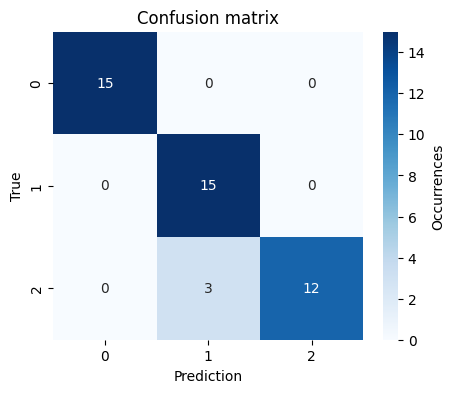

In [7]:
# get the confusion matrix of test set
confusion_test = confusion_matrix(y_test, y_test_pred)

# visualize the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'})
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

### 2. Exercise - RTP dataset
In this exercise, we employ a different dataset, which contains RTP traffic information. The Real-time Transport Protocol (RTP) is a network protocol for delivering real-time audio and video over IP networks. RTP is used in communication and entertainment systems that involve streaming media, such as telephony, video teleconference applications including WebRTC, television services and web-based push-to-talk features. In this laboratory, you will work on traces referred to Webex conference call to perform a classification task. Specifically, the traffic was collected on client side during video-conferencing. The traffic is basically the traces (records) of RTP packets following chronological order. Afterwards, we define successive time windows and aggregate packets in each time window, calculating certain statistics, which can be considered a statistical representation of the traffic in such time window.

![](video_conference.png)

### 2.1 Loading the dataset
Unzip the RTP_dataset.csv.zip to get the csv dataset describing RTP traffic. Each record describes 1 second of a traffic (packet aggregation) carrying different class of data. Each record reports 95 features including statistics on:
- Packet size
- Interarrival time*
- RTP interarrival time*
- Interlength*
- Label describing the class of data carried by the flow.
<br>*inter statistics are computed based on the difference between the current and previous packet. For example, if packet 1 is received at 30s and packet 2 is received at 31s, the interarrival time between those two will be 1s.

Each record (row) belongs to a single class. 3 main classes exist: **Audio, Video, Screen Sharing**. In particular, audio class consists of two sub-classes, **Audio and FEC-Audio**, and video class can be further split in 4 more sub-classes: **High Quality (>=720p), Medium Quality (360p<x<720p), Low Quality (<=360p), and FEC-Video**.

In [8]:
df = pd.read_csv("RTP_dataset.csv")
df

,interarrival_std,interarrival_mean,interarrival_min,interarrival_max,interarrival_max_min_diff,interarrival_p10,interarrival_p20,interarrival_p25,interarrival_p30,interarrival_p40,...,rtp_interarrival_max_min_R,rtp_interarrival_kurtosis,rtp_interarrival_skew,rtp_interarrival_moment3,rtp_interarrival_moment4,rtp_interarrival_len_unique_percent,rtp_interarrival_max_value_count_percent,rtp_interarrival_min_max_R,rtp_marker_sum_check,label
0,0.001927,0.010000,0.004951,0.014423,0.009472,7.619953e-05,8.045912e-05,8.572698e-05,9.030223e-05,9.799051e-05,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.010000,1.000000,0.500000,0,Audio
1,0.000515,0.020009,0.019227,0.021251,0.002024,1.931565e-04,1.953020e-04,1.958430e-04,1.965890e-04,1.985469e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.020000,1.000000,0.500000,0,Audio
2,0.041315,0.019994,0.000000,0.143393,0.143393,9.536743e-09,9.536743e-09,9.536743e-09,1.907349e-08,4.053116e-08,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.019231,1.000000,0.500000,0,Audio
3,0.008119,0.019954,0.000873,0.044432,0.043559,9.701633e-05,1.477895e-04,1.699674e-04,1.779909e-04,1.895509e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.020000,1.000000,0.500000,0,Audio
4,0.018683,0.020117,0.000001,0.121093,0.121092,1.023531e-05,7.453918e-05,1.209468e-04,1.324451e-04,1.531601e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.021739,1.000000,0.500000,0,Audio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,0.000799,0.337698,0.336812,0.338365,0.001553,3.370330e-03,3.372540e-03,3.373646e-03,3.374751e-03,3.376961e-03,...,0.511905,-1.500000,-0.707107,-2.211840e+08,3.185050e+11,0.666667,0.666667,0.488095,3,ScreenSharing
139996,0.159892,0.239946,0.000108,0.320163,0.320055,9.596729e-04,1.918266e-03,2.397562e-03,2.876859e-03,3.196862e-03,...,1.000000,-0.671026,-1.148811,-2.524719e+12,6.654528e+16,1.000000,0.250000,0.000000,3,ScreenSharing
139997,0.045574,0.040176,0.000012,0.151814,0.151802,1.705837e-05,3.843689e-05,6.171942e-05,1.125135e-04,2.727780e-04,...,0.500000,-3.000000,0.000000,0.000000e+00,0.000000e+00,0.043478,1.000000,0.500000,23,ScreenSharing
139998,0.028728,0.325410,0.299745,0.356444,0.056699,3.038041e-03,3.078630e-03,3.098925e-03,3.119220e-03,3.159810e-03,...,0.511144,-1.500000,-0.695813,-1.628640e+08,2.163721e+11,1.000000,0.333333,0.488856,3,ScreenSharing


### 2.2 Binary classification
From now on, we focus on two major classes, **Video** and **Audio**, and you need to develop ML pipeline to classify the traffic based on statistical features. Specifically, you will perform the following steps:
- Data preprocessing
- Model development (perform ERM with an algorithm)
- Performance evaluation

### 2.2.1 Dataset preprocessing - Data split and standardization
- Extract data only associated to the aforementioned classes.
- For an individual class, assign a numerical label (0 to Video and 1 to Audio).
- Split the whole dataset into training and test. Stratify the split, keeping the 70/30 proportion (i.e., the training dataset contains the 70% of the sample per label, the test contains the remaining 30% per label).
- After the splitting, standardize the data (features). Fit the StandardScaler only on the training set and then transform both the training and test sets. From now on, you will use the same standardize datasets for all the experiments.

In [11]:
# This part is provided

# extract data from Video and Audio
# we have to perform a copy of the dataset otherwise we will modify the original dataset

video  = ['FEC-Video', 'HighQ', 'LowQ', 'MediumQ']
audio  = ['Audio', 'FEC-Audio']
screen = ['ScreenSharing']

video_data  = df[df["label"].isin(video)].copy()
audio_data  = df[df["label"].isin(audio)].copy()

video_data["binary_label"]=0
audio_data["binary_label"]=1

video_data = video_data.drop("label",axis=1)
audio_data = audio_data.drop("label",axis=1)

binary_dataset = pd.concat([video_data, audio_data])

# prepare the new dataset
# get the X and y from the dataset
X = binary_dataset.drop(columns=['binary_label']).to_numpy()
y = binary_dataset[['binary_label']].to_numpy()

In [12]:
# run stratified training-test splitting using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.7, random_state=15)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

# standardize data using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

### 2.2.2 Dataset preprocessing - Removal of correlated features
- For the training set, compute and display the correlation matrix between the features (refer to lab 2 for details).
- Remove strongly correlated features from both training and test sets, i.e., features having a correlation > 0.8. Note that a feature may be strongly correlated with many others.
    - How many correlated features you have to remove?

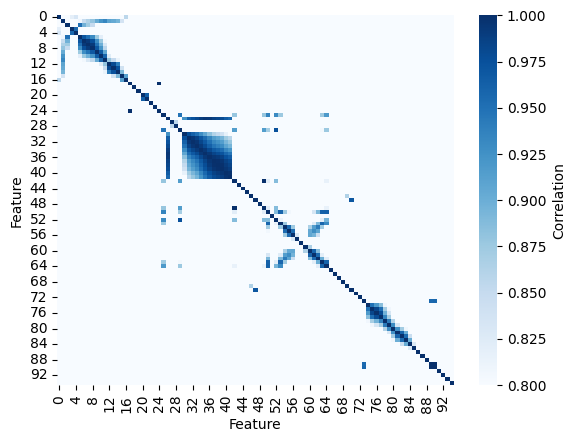

In [13]:
# Here everything is provided

# compute the correlation matrix
columns= [i for i in range(X_train_s.shape[1])]
df_tmp = pd.DataFrame(X_train_s, columns=columns)
correlation_matrix = df_tmp.corr().abs()

# display the heatmap
plt.figure()
sns.heatmap(correlation_matrix, cmap='Blues', vmin=0.8, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.show()

In [14]:
# extract features having a correlation > 0.8
c = correlation_matrix[correlation_matrix>0.8]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# get strongly correlatead features removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull()==False) & (so["level_0"] != so["level_1"])]

to_be_deleted = []
candidates = list(so["level_0"])

# get the unique set of features to be deleted. Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])): 
        to_be_deleted.append(candidate)
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (subset_so["level_1"] != candidate)]

# to_be_deleted contains the index of columns that you need to remove from both training and test sets
print(len(to_be_deleted), 'features are removed')

# remove the correlated features from bot sets

# Create a mask for the columns to keep
columns_to_keep = np.ones(X_train_s.shape[1], dtype=bool)
columns_to_keep[to_be_deleted] = False

# Use the mask to select only the columns to keep
X_train_s = X_train_s[:, columns_to_keep]
X_test_s = X_test_s[:, columns_to_keep]

57 features are removed


### 2.2.3 Model development
- Refer to the following 3 algorithms and train the models with predefined parameters:
    - k-Nearest Neighbors (k-NN) (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">sklearn</a>), with parameters of ``n_neighbors=3``.
    - Logistic Regression (LR) (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression">sklearn</a>), with parameters of ``max_iter=150``.
    - Random Forest (RF) (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier">sklearn</a>), with parameters of ``n_estimators=30``.
  
    Explain how each parameter will affect the algorithm
- After the model training, use the obtained hypothesis to obtain predictions not only for test set but also for training set.

In [15]:
# k-NN
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_s, y_train)
y_train_pred_knn = knn_clf.predict(X_train_s)
y_test_pred_knn = knn_clf.predict(X_test_s)

# LR
lr_clf = LogisticRegression(max_iter=150)
lr_clf.fit(X_train_s, y_train)
y_train_pred_lr = lr_clf.predict(X_train_s)
y_test_pred_lr = lr_clf.predict(X_test_s)

# RF
rf_clf = RandomForestClassifier(n_estimators=30)
rf_clf.fit(X_train_s, y_train)
y_train_pred_rf = rf_clf.predict(X_train_s)
y_test_pred_rf = rf_clf.predict(X_test_s)

/Users/stlssg/Library/Python/3.11/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.2.4 Performance evaluation
- Now you should have derived 3 sets of predictions for both training and test sets for all models. Evaluate all the 6 predictions, computing and displaying numerical metrics (classification report) and confusion matrix.
- Answering the following questions:
    - Which model produces the best performance? Why do you think so?
    - For each model, which class is better classified? Are they different among models?
    - For each model, do you observe the phenomenon of overfitting or underfitting? Why do you think so?

Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00     28000

    accuracy                           1.00     84000
   macro avg       1.00      1.00      1.00     84000
weighted avg       1.00      1.00      1.00     84000

Test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     12000

    accuracy                           1.00     36000
   macro avg       1.00      1.00      1.00     36000
weighted avg       1.00      1.00      1.00     36000



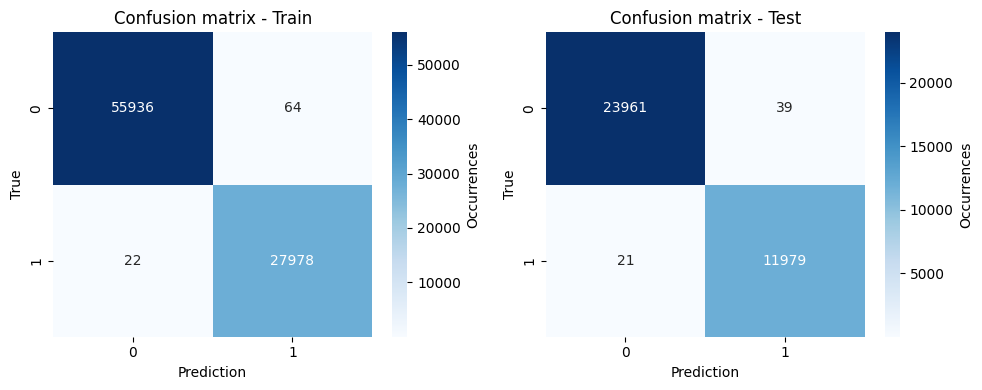

In [16]:
# k-NN

# classification report
print('Training set')
print(classification_report(y_train, y_train_pred_knn))
print('Test set')
print(classification_report(y_test, y_test_pred_knn))

# get the confusion matrix & visualize the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

confusion_train = confusion_matrix(y_train, y_train_pred_knn)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')

plt.tight_layout()
plt.show()

Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00     28000

    accuracy                           1.00     84000
   macro avg       1.00      1.00      1.00     84000
weighted avg       1.00      1.00      1.00     84000

Test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     12000

    accuracy                           1.00     36000
   macro avg       1.00      1.00      1.00     36000
weighted avg       1.00      1.00      1.00     36000



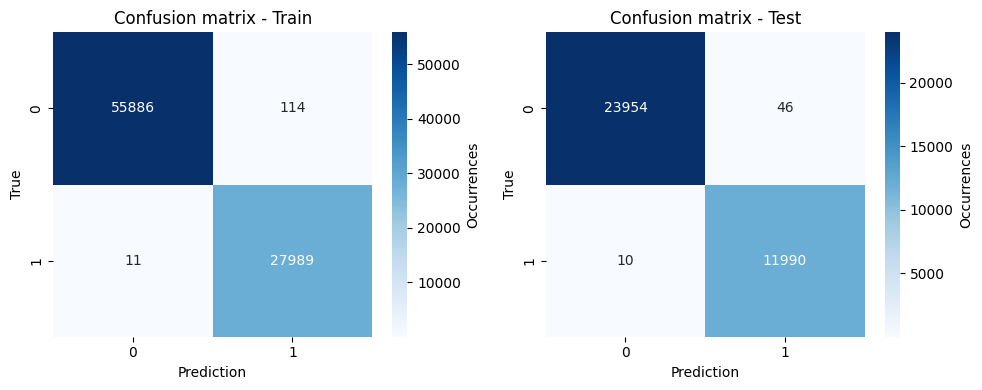

In [17]:
# LR

# classification report
print('Training set')
print(classification_report(y_train, y_train_pred_lr))
print('Test set')
print(classification_report(y_test, y_test_pred_lr))

# get the confusion matrix & visualize the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

confusion_train = confusion_matrix(y_train, y_train_pred_lr)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')

plt.tight_layout()
plt.show()

Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00     28000

    accuracy                           1.00     84000
   macro avg       1.00      1.00      1.00     84000
weighted avg       1.00      1.00      1.00     84000

Test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24000
           1       1.00      1.00      1.00     12000

    accuracy                           1.00     36000
   macro avg       1.00      1.00      1.00     36000
weighted avg       1.00      1.00      1.00     36000



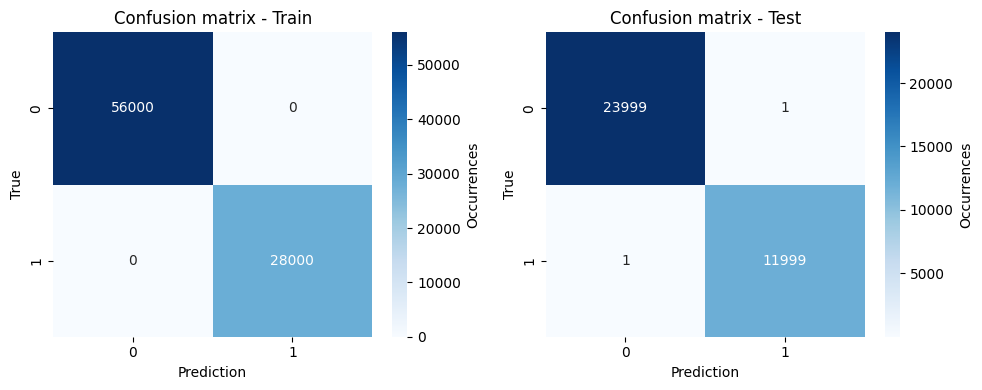

In [18]:
# RF

# classification report
print('Training set')
print(classification_report(y_train, y_train_pred_rf))
print('Test set')
print(classification_report(y_test, y_test_pred_rf))

# get the confusion matrix & visualize the confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

confusion_train = confusion_matrix(y_train, y_train_pred_rf)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')

plt.tight_layout()
plt.show()

### 2.3 Regression analysis
Here we intend to investigate the possibility of representing a certain feature through other features by performing a regression analysis. In other words, we may find a relationship between a feature and the others. Specifically, we focus on `interarrival_std`, and you need to do the following:
- Refer to the original dataset and remove the correlated features as you have done previously.
- Randomly split the dataset into training and test set (70/30 and no need of stratification), and standardize the dataset as you have done previously.
- Refer to linear regression and decision tree regressor, by training scikit-learn models with default configuration. Documentations:  <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear regression</a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor">Decision tree regressor</a>.
- Make predictions for both of training and test sets.
- Output performance metrics for both sets and for both models by calculating Mean Squared Error (MSE) and the Mean Absolute Error (MAE). There're also scikit-learn library doing the job. Answer the following:
    - Do you observe overfitting or under-fitting?
    - Which model performs better?

In [19]:
df_ = df.drop(df.columns[to_be_deleted], axis='columns').copy()

X = df_.drop(columns=['label', 'interarrival_std']).to_numpy()
y = df_[['interarrival_std']].to_numpy()

# run stratified training-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=15)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

# standardize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

In [20]:
lr = LinearRegression()
lr.fit(X_train_s, y_train)
y_train_pred_lr = lr.predict(X_train_s)
y_test_pred_lr = lr.predict(X_test_s)

dtr = DecisionTreeRegressor()
dtr.fit(X_train_s, y_train)
y_train_pred_dtr = dtr.predict(X_train_s)
y_test_pred_dtr = dtr.predict(X_test_s)

In [21]:
def output_performance(trues_train, preds_train, trues_test, preds_test, model_name):
    print(model_name)
    print('Training set:')
    print('Mean squared error:', mean_squared_error(trues_train, preds_train))
    print('Mean absolte error:', mean_absolute_error(trues_train, preds_train))
    print('Test set:')
    print('Mean squared error:', mean_squared_error(trues_test, preds_test))
    print('Mean absolte error:', mean_absolute_error(trues_test, preds_test))
    print()

In [22]:
output_performance(y_train, y_train_pred_lr, y_test, y_test_pred_lr, 'Linear regression')
output_performance(y_train, y_train_pred_dtr, y_test, y_test_pred_dtr, 'Decision tree regressor')

Linear regression
Training set:
Mean squared error: 8.193538548224158e-05
Mean absolte error: 0.004734902360365008
Test set:
Mean squared error: 7.634570161641026e-05
Mean absolte error: 0.004711850053356113

Decision tree regressor
Training set:
Mean squared error: 2.555136367485473e-19
Mean absolte error: 2.5793045377593295e-11
Test set:
Mean squared error: 9.8962033391124e-06
Mean absolte error: 0.0007812837080926388

